In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


In [54]:
df = pd.read_csv('hh_kz_it_vacancies.csv')
df.head()

,id,name,area,employer,salary_from,salary_to,salary_currency,published_at,experience,employment,schedule,key_skills,specialization,professional_roles
0,126266590,"Human Resources Business Partner, Almaty factory",Алматы,JTI Kazakhstan,NaN,NaN,NaN,2025-10-07,От 3 до 6 лет,Полная занятость,Полный день,NaN,NaN,Методолог
1,126282155,Ведущий специалист по методологии,Алматы,KAZ Minerals Management,NaN,NaN,NaN,2025-10-08,От 1 года до 3 лет,Полная занятость,Полный день,NaN,NaN,Методолог
2,126058897,Разработчик чат-ботов (методолог),Алматы,Интернет-коммуникации,250000.0,300000.0,KZT,2025-10-02,Нет опыта,Полная занятость,Удаленная работа,NaN,NaN,Методолог
3,126268215,SAP Project Manager,Алматы,Terralink Technologies LLC,NaN,NaN,NaN,2025-10-07,От 1 года до 3 лет,Полная занятость,Удаленная работа,NaN,NaN,Методолог
4,126288271,Ведущий менеджер Группы анализа и методологии,Алматы,Jusan Mobile,NaN,NaN,NaN,2025-10-08,От 3 до 6 лет,Полная занятость,Полный день,NaN,NaN,Методолог


In [55]:
df.shape

(2863, 14)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2863 non-null   int64  
 1   name                2863 non-null   object 
 2   area                2863 non-null   object 
 3   employer            2863 non-null   object 
 4   salary_from         1122 non-null   float64
 5   salary_to           866 non-null    float64
 6   salary_currency     1217 non-null   object 
 7   published_at        2863 non-null   object 
 8   experience          2863 non-null   object 
 9   employment          2863 non-null   object 
 10  schedule            2863 non-null   object 
 11  key_skills          0 non-null      float64
 12  specialization      0 non-null      float64
 13  professional_roles  2863 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 313.3+ KB


In [57]:
df.describe()

,id,salary_from,salary_to,key_skills,specialization
count,2.863000e+03,1.122000e+03,8.660000e+02,0.0,0.0
mean,1.253277e+08,3.476684e+05,5.311100e+05,NaN,NaN
std,2.044715e+06,2.410466e+05,4.180243e+05,NaN,NaN
min,9.273679e+07,1.000000e+01,1.500000e+01,NaN,NaN
25%,1.252538e+08,2.000000e+05,2.712500e+05,NaN,NaN
50%,1.256099e+08,3.000000e+05,4.000000e+05,NaN,NaN
75%,1.260018e+08,4.946250e+05,7.000000e+05,NaN,NaN
max,1.263066e+08,1.693000e+06,3.000000e+06,NaN,NaN


In [58]:
df.isnull().sum()

id                       0
name                     0
area                     0
employer                 0
salary_from           1741
salary_to             1997
salary_currency       1646
published_at             0
experience               0
employment               0
schedule                 0
key_skills            2863
specialization        2863
professional_roles       0
dtype: int64

In [59]:
df = df.drop(columns=['key_skills','specialization'])
df.head()

,id,name,area,employer,salary_from,salary_to,salary_currency,published_at,experience,employment,schedule,professional_roles
0,126266590,"Human Resources Business Partner, Almaty factory",Алматы,JTI Kazakhstan,NaN,NaN,NaN,2025-10-07,От 3 до 6 лет,Полная занятость,Полный день,Методолог
1,126282155,Ведущий специалист по методологии,Алматы,KAZ Minerals Management,NaN,NaN,NaN,2025-10-08,От 1 года до 3 лет,Полная занятость,Полный день,Методолог
2,126058897,Разработчик чат-ботов (методолог),Алматы,Интернет-коммуникации,250000.0,300000.0,KZT,2025-10-02,Нет опыта,Полная занятость,Удаленная работа,Методолог
3,126268215,SAP Project Manager,Алматы,Terralink Technologies LLC,NaN,NaN,NaN,2025-10-07,От 1 года до 3 лет,Полная занятость,Удаленная работа,Методолог
4,126288271,Ведущий менеджер Группы анализа и методологии,Алматы,Jusan Mobile,NaN,NaN,NaN,2025-10-08,От 3 до 6 лет,Полная занятость,Полный день,Методолог


In [60]:
df.duplicated().sum()

np.int64(0)

In [61]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")

In [62]:
def salary_mean(row):
    f, t = row["salary_from"], row["salary_to"]
    if pd.notnull(f) and pd.notnull(t): return (f + t) / 2
    if pd.notnull(f): return f
    if pd.notnull(t): return t
    return np.nan

df["salary_avg"] = df.apply(salary_mean, axis=1)
df.head()

,id,name,area,employer,salary_from,salary_to,salary_currency,published_at,experience,employment,schedule,professional_roles,salary_avg
0,126266590,"Human Resources Business Partner, Almaty factory",Алматы,JTI Kazakhstan,NaN,NaN,NaN,2025-10-07,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN
1,126282155,Ведущий специалист по методологии,Алматы,KAZ Minerals Management,NaN,NaN,NaN,2025-10-08,От 1 года до 3 лет,Полная занятость,Полный день,Методолог,NaN
2,126058897,Разработчик чат-ботов (методолог),Алматы,Интернет-коммуникации,250000.0,300000.0,KZT,2025-10-02,Нет опыта,Полная занятость,Удаленная работа,Методолог,275000.0
3,126268215,SAP Project Manager,Алматы,Terralink Technologies LLC,NaN,NaN,NaN,2025-10-07,От 1 года до 3 лет,Полная занятость,Удаленная работа,Методолог,NaN
4,126288271,Ведущий менеджер Группы анализа и методологии,Алматы,Jusan Mobile,NaN,NaN,NaN,2025-10-08,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN


In [63]:
df['salary_currency'].value_counts()

salary_currency
KZT    1115
USD      67
RUR      27
EUR       7
KGS       1
Name: count, dtype: int64

In [64]:
def convert_to_kzt(salary, currency):
    if pd.isnull(salary) or pd.isnull(currency):
        return None
    conversion_rates = {'KZT': 1, 'RUR': 6.64, 'EUR': 628.54, 'USD': 540.43, 'KGS': 6.18 }

    rate = conversion_rates.get(currency.upper())
    return salary * rate

In [65]:
df['salary_avg'] = df.apply(lambda x: convert_to_kzt(x["salary_avg"], x["salary_currency"]), axis=1)
df = df.drop(columns=['salary_from','salary_to','salary_currency'])
df.head()

,id,name,area,employer,published_at,experience,employment,schedule,professional_roles,salary_avg
0,126266590,"Human Resources Business Partner, Almaty factory",Алматы,JTI Kazakhstan,2025-10-07,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN
1,126282155,Ведущий специалист по методологии,Алматы,KAZ Minerals Management,2025-10-08,От 1 года до 3 лет,Полная занятость,Полный день,Методолог,NaN
2,126058897,Разработчик чат-ботов (методолог),Алматы,Интернет-коммуникации,2025-10-02,Нет опыта,Полная занятость,Удаленная работа,Методолог,275000.0
3,126268215,SAP Project Manager,Алматы,Terralink Technologies LLC,2025-10-07,От 1 года до 3 лет,Полная занятость,Удаленная работа,Методолог,NaN
4,126288271,Ведущий менеджер Группы анализа и методологии,Алматы,Jusan Mobile,2025-10-08,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN


In [66]:
df["ym"] = df["published_at"].dt.to_period("M").dt.to_timestamp()
df.head()

,id,name,area,employer,published_at,experience,employment,schedule,professional_roles,salary_avg,ym
0,126266590,"Human Resources Business Partner, Almaty factory",Алматы,JTI Kazakhstan,2025-10-07,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN,2025-10-01
1,126282155,Ведущий специалист по методологии,Алматы,KAZ Minerals Management,2025-10-08,От 1 года до 3 лет,Полная занятость,Полный день,Методолог,NaN,2025-10-01
2,126058897,Разработчик чат-ботов (методолог),Алматы,Интернет-коммуникации,2025-10-02,Нет опыта,Полная занятость,Удаленная работа,Методолог,275000.0,2025-10-01
3,126268215,SAP Project Manager,Алматы,Terralink Technologies LLC,2025-10-07,От 1 года до 3 лет,Полная занятость,Удаленная работа,Методолог,NaN,2025-10-01
4,126288271,Ведущий менеджер Группы анализа и методологии,Алматы,Jusan Mobile,2025-10-08,От 3 до 6 лет,Полная занятость,Полный день,Методолог,NaN,2025-10-01


# EDA

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  2863 non-null   int64         
 1   name                2863 non-null   object        
 2   area                2863 non-null   object        
 3   employer            2863 non-null   object        
 4   published_at        2863 non-null   datetime64[ns]
 5   experience          2863 non-null   object        
 6   employment          2863 non-null   object        
 7   schedule            2863 non-null   object        
 8   professional_roles  2863 non-null   object        
 9   salary_avg          1217 non-null   float64       
 10  ym                  2863 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 246.2+ KB


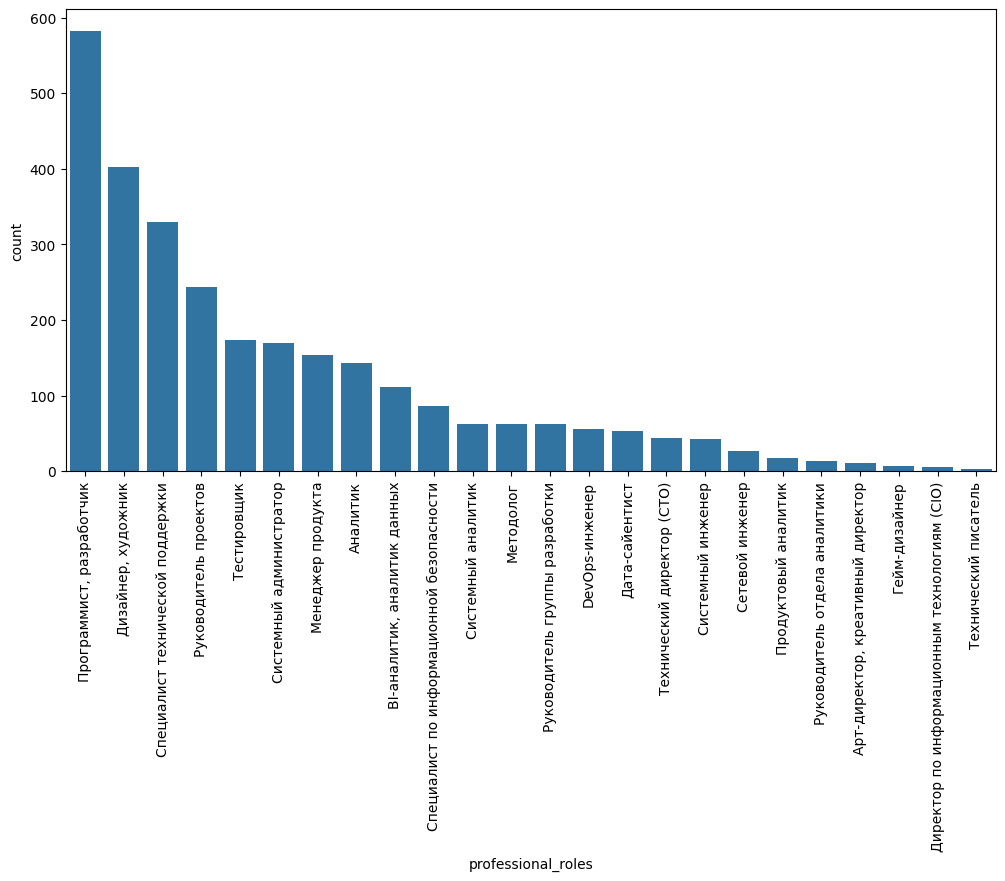

In [68]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'professional_roles', order=df['professional_roles'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

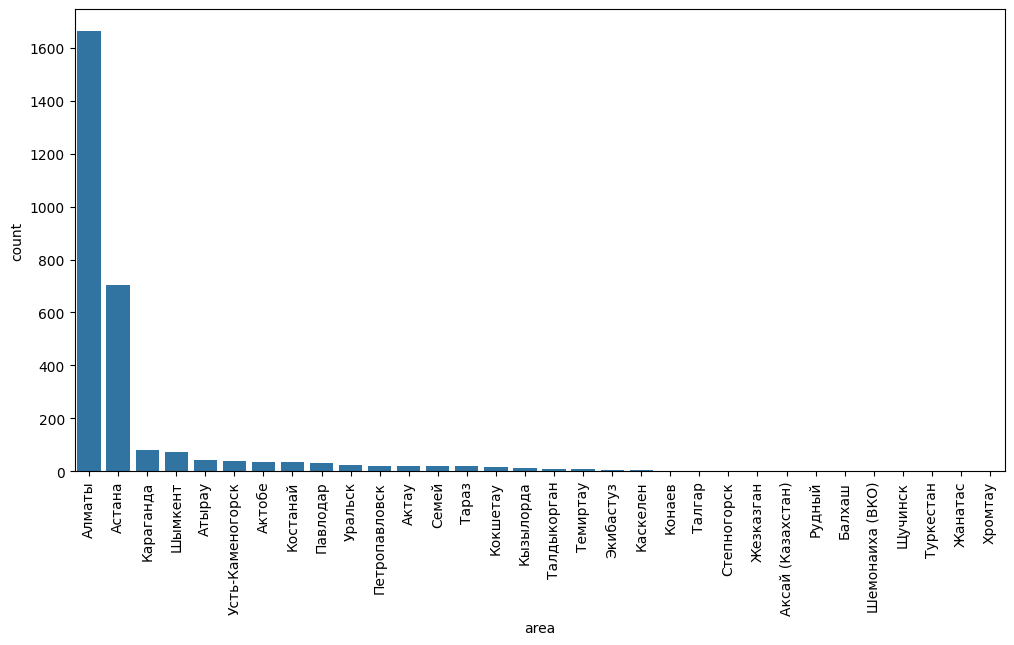

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'area', order=df['area'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

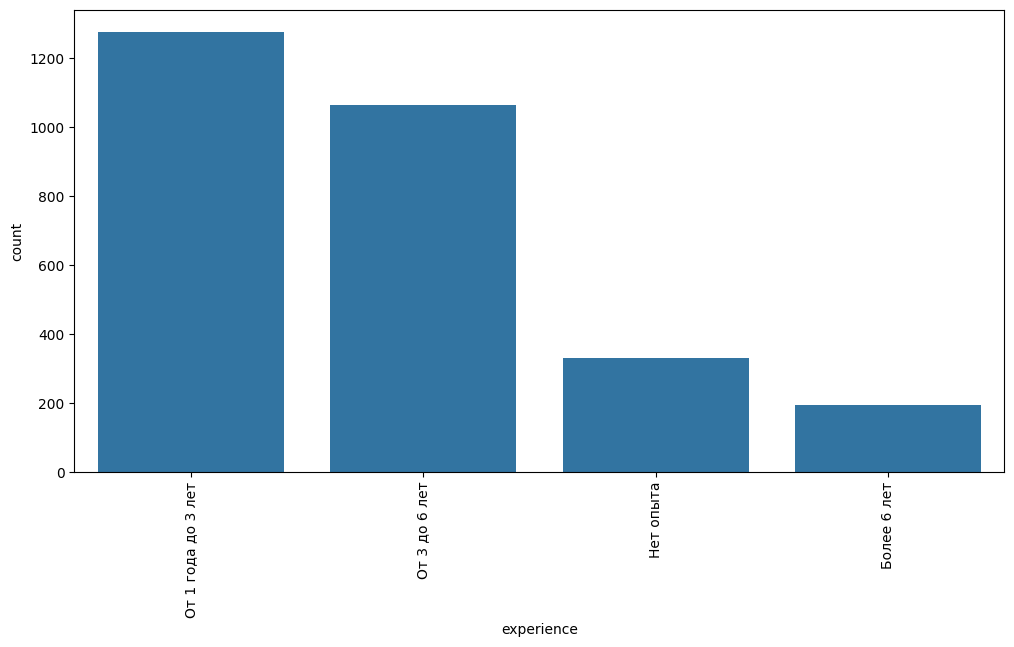

In [70]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'experience', order=df['experience'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [71]:
df['employer'].value_counts().head(10)

employer
Epam Kazakhstan (Эпам Казахстан),ТОО                         86
Andersen                                                     53
Beeline, ТМ                                                  41
Народный банк Казахстана                                     33
Яндекс                                                       30
АО «Freedom Bank Kazakhstan»                                 29
Мобайл Телеком-Сервис (Объединенная Компания Tele2/Altel)    27
Alatau City Bank                                             25
Банк ЦентрКредит                                             23
red_mad_robot                                                22
Name: count, dtype: int64

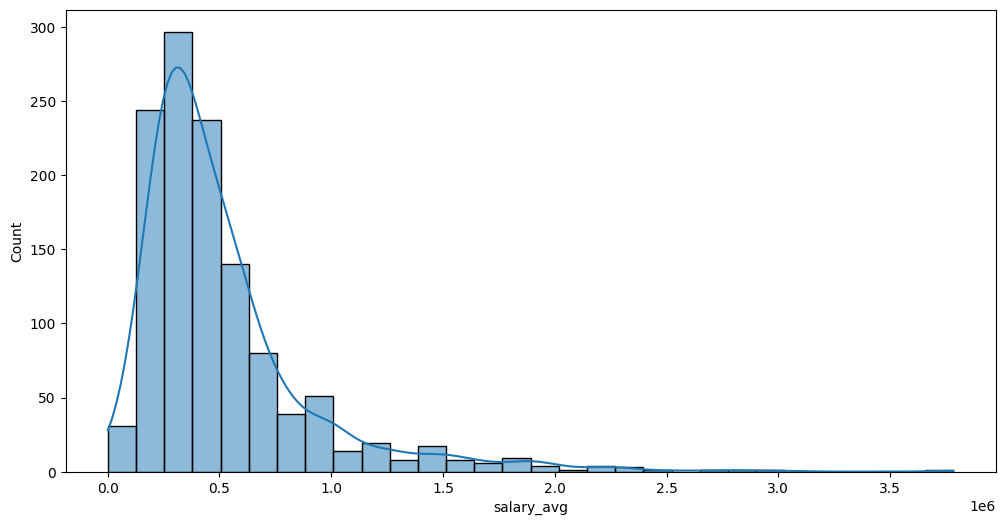

In [72]:
plt.figure(figsize=(12,6))
sns.histplot(df['salary_avg'], kde=True, bins=30)
plt.show()

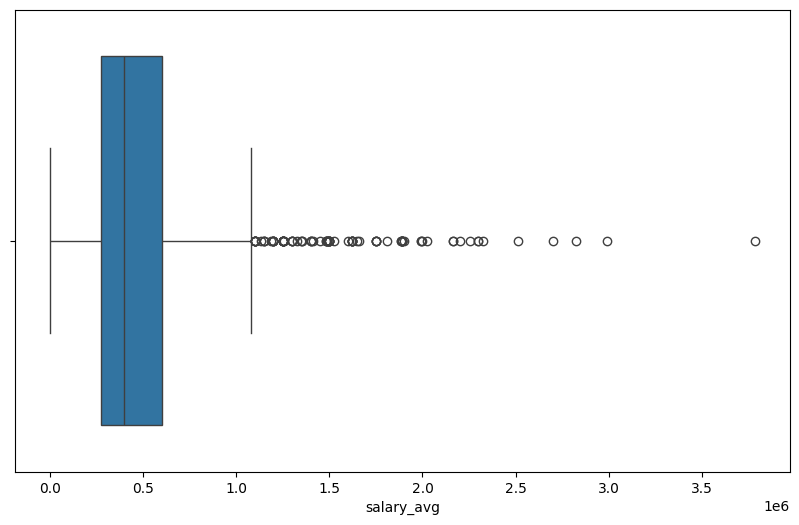

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,x='salary_avg')
plt.show()

<Axes: ylabel='professional_roles'>

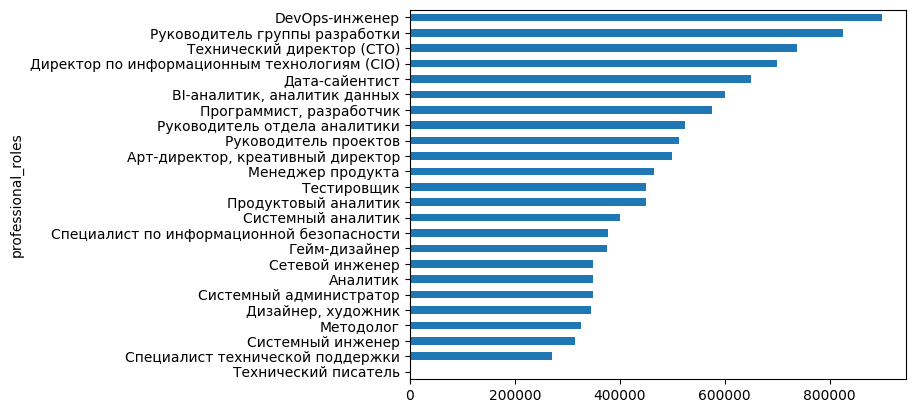

In [74]:
salary_cat = (df.groupby("professional_roles")["salary_avg"].median().sort_values(ascending=False))
salary_cat
salary_cat.sort_values(na_position="first").plot(kind="barh")


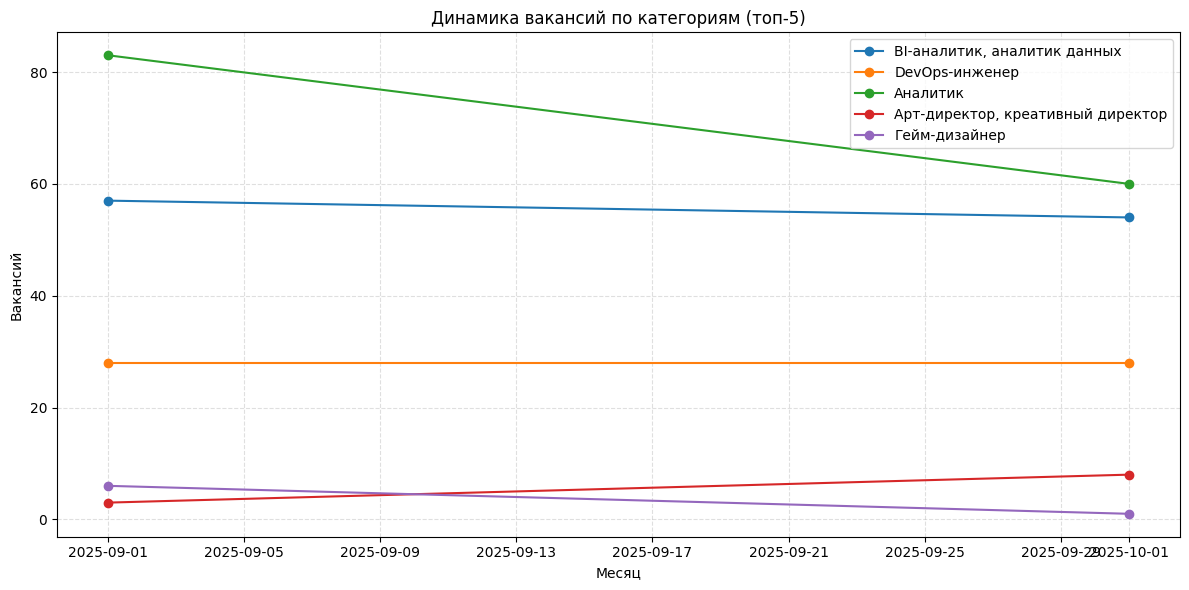

In [75]:
by_cat_month = (df.groupby(["ym","professional_roles"])["id"].nunique().reset_index(name="vacancies"))
cats = by_cat_month["professional_roles"].value_counts().index.tolist()
plt.figure(figsize=(12,6))
for c in cats[:5]:  
    s = by_cat_month[by_cat_month["professional_roles"]==c]
    plt.plot(s["ym"], s["vacancies"], marker="o", label=c)
plt.title("Динамика вакансий по категориям (топ-5)")
plt.xlabel("Месяц"); 
plt.ylabel("Вакансий")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
df.to_csv('hh_kz_it_vacancies_final-1.csv', index=False)

# Data preprocessing

In [77]:
df = df.drop(columns=['id','name','area','employer','employment','schedule','experience','salary_avg','ym'])
df.head()

,published_at,professional_roles
0,2025-10-07,Методолог
1,2025-10-08,Методолог
2,2025-10-02,Методолог
3,2025-10-07,Методолог
4,2025-10-08,Методолог


In [78]:
df['published_at'] = pd.to_datetime(df['published_at'])

In [79]:
weekly = df.groupby([
    pd.Grouper(key="published_at", freq="W"),
    "professional_roles"
]).size().reset_index(name="count")

In [80]:
pivot = weekly.pivot(index="published_at", columns="professional_roles", values="count").fillna(0)
pivot.head()

professional_roles,"BI-аналитик, аналитик данных",DevOps-инженер,Аналитик,"Арт-директор, креативный директор",Гейм-дизайнер,Дата-сайентист,"Дизайнер, художник",Директор по информационным технологиям (CIO),Менеджер продукта,Методолог,...,Руководитель проектов,Сетевой инженер,Системный администратор,Системный аналитик,Системный инженер,Специалист по информационной безопасности,Специалист технической поддержки,Тестировщик,Технический директор (CTO),Технический писатель
published_at,,,,,,,,,,,,,,,,,,,,,
2025-09-14,18.0,7.0,20.0,1.0,1.0,4.0,60.0,0.0,21.0,12.0,...,35.0,4.0,18.0,17.0,1.0,8.0,53.0,15.0,4.0,0.0
2025-09-21,12.0,11.0,29.0,1.0,0.0,4.0,71.0,2.0,29.0,6.0,...,43.0,5.0,29.0,12.0,7.0,15.0,43.0,16.0,10.0,0.0
2025-09-28,20.0,4.0,23.0,1.0,2.0,14.0,62.0,1.0,21.0,13.0,...,36.0,6.0,28.0,9.0,10.0,14.0,51.0,19.0,9.0,0.0
2025-10-05,24.0,22.0,29.0,4.0,3.0,14.0,101.0,0.0,34.0,13.0,...,54.0,5.0,37.0,15.0,8.0,18.0,88.0,54.0,4.0,1.0
2025-10-12,37.0,12.0,42.0,4.0,1.0,17.0,109.0,2.0,49.0,18.0,...,76.0,7.0,58.0,10.0,17.0,31.0,95.0,69.0,17.0,2.0


# Stability test

In [81]:
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

In [82]:
test_stationarity(weekly['count'])

ADF Statistic: -1.6205110649436651
p-value: 0.47246137620048795
The series is non-stationary.


<Axes: >

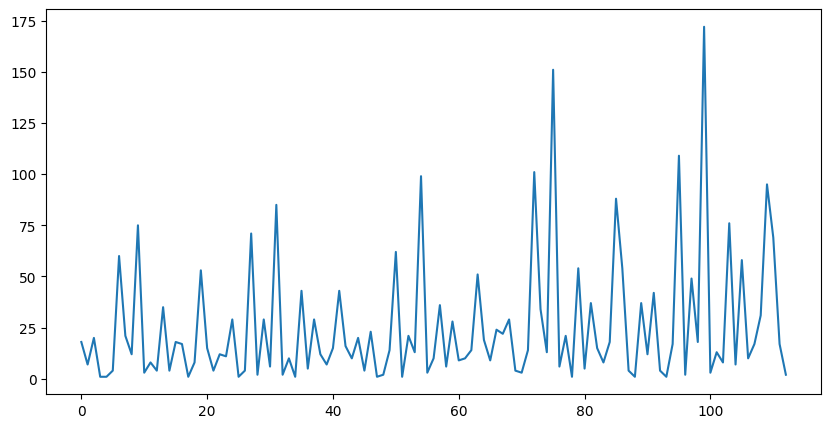

In [83]:
weekly['count'].plot(figsize=(10,5))

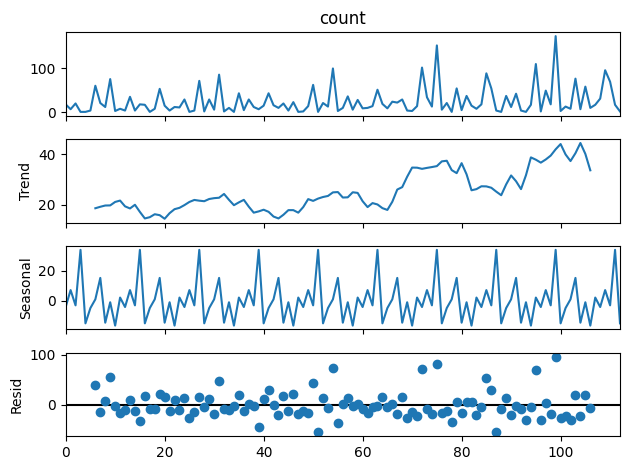

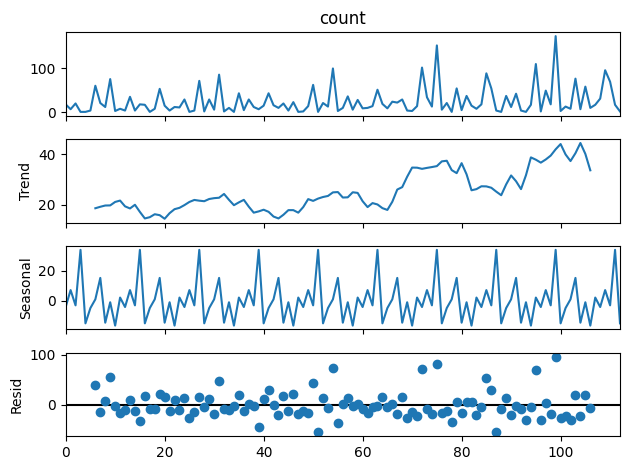

In [84]:
data = weekly['count']
decomposition = seasonal_decompose(data, model='additive', period=12)
decomposition.plot()


# Model Evaluation

In [85]:
def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "MSE": mse}

In [86]:
def ranking(forecast):
    ranking = pd.Series(forecast).sort_values(ascending=False)
    print("Top roles expected to be in demand:")
    print(ranking.head(10))
    return ranking

In [87]:
def average_metrics(metrics_list):
    metrics_df = pd.DataFrame(metrics_list, columns=["Model", "MAE", "RMSE", "MSE"])
    print("\nOverall model performance:")
    print(metrics_df.groupby("Model").mean().reset_index())

In [88]:
def visualize_forecast(ranking):
    top_roles = ranking.head(5).index
    pivot[top_roles].plot(figsize=(10,5))
    plt.title("Top 5 IT Roles — Weekly Vacancy Trends")
    plt.ylabel("Vacancies per Week")
    plt.xlabel("Week")
    plt.grid(True)
    plt.show()
    

In [89]:
window = 2                 
test_horizon = 2           
min_points = window + 2   
metrics_list = []


# Naive / Moving Average

In [90]:
for role in pivot.columns:
    series = pivot[role].astype(float)

    if len(series.dropna()) < min_points:
        continue

    train = series.iloc[:-test_horizon]
    test  = series.iloc[-test_horizon:]

    const_val = float(train.iloc[-1])
    y_pred = pd.Series(const_val, index=test.index)

    metrics_list.append(evaluate_forecast(test, y_pred, "Naive"))

average_metrics(metrics_list)


Overall model performance:
   Model        MAE       RMSE     MSE
0  Naive  14.291667  15.138301  510.25


In [91]:
for role in pivot.columns:
    series = pivot[role].astype(float)

    if len(series.dropna()) < min_points:
        continue

    train = series.iloc[:-test_horizon]
    test  = series.iloc[-test_horizon:]

    ma_val = float(train.tail(window).mean())
    y_pred = pd.Series(ma_val, index=test.index)

    metrics_list.append(evaluate_forecast(test, y_pred, 'Moving average'))

average_metrics(metrics_list)



Overall model performance:
            Model        MAE       RMSE         MSE
0  Moving average  14.479167  15.375586  538.708333
1           Naive  14.291667  15.138301  510.250000


# ARIMA

In [92]:
def gridsearch_arima(s):
    grid=((0,1,0),(1,1,0),(0,1,1),(1,1,1))
    best = None
    best_aic = np.inf
    for p,d,q in grid:
        try:
            fit = ARIMA(s, order=(p,d,q)).fit()
            if fit.aic < best_aic:
                best_aic = fit.aic
                best = ((p,d,q), fit)
        except Exception:
            continue
    return best
    


In [93]:
for role in pivot.columns:
    series = pivot[role]
    
    if series.sum() < min_points:
        continue

    train = series.iloc[:-test_horizon]
    test  = series.iloc[-test_horizon:]
    
    model = gridsearch_arima(train)
    fitted = model[1]
    forecast = fitted.forecast(steps=len(test)) 
    y_pred = pd.Series(forecast.values, index=test.index, name="arima_pred")
    metrics_list.append(evaluate_forecast(test, y_pred, 'Arima'))

average_metrics(metrics_list)


C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra


Overall model performance:
            Model        MAE       RMSE         MSE
0           Arima  13.999364  14.949718  435.898048
1  Moving average  14.479167  15.375586  538.708333
2           Naive  14.291667  15.138301  510.250000


C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

# ETS

In [94]:
for role in pivot.columns:
    series = pivot[role]

    if len(series.dropna()) < min_points:
        continue
    
    train = series.iloc[:-test_horizon]
    test  = series.iloc[-test_horizon:]

    
    model = ExponentialSmoothing(train, trend="add", seasonal=None)
    fitted = model.fit(optimized=True)

    forecast = fitted.forecast(steps=len(test))
    y_pred = pd.Series(forecast.values, index=test.index, name="ets_pred")

    metrics_list.append(evaluate_forecast(test, y_pred, 'ETS'))

average_metrics(metrics_list)



C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra


Overall model performance:
            Model        MAE       RMSE         MSE
0           Arima  13.999364  14.949718  435.898048
1             ETS  12.944443  13.757374  390.599507
2  Moving average  14.479167  15.375586  538.708333
3           Naive  14.291667  15.138301  510.250000


C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

# Prophet

In [95]:
for role in pivot.columns:
    subset = weekly[weekly["professional_roles"] == role][["published_at", "count"]]
    subset = subset.rename(columns={"published_at": "ds", "count": "y"})
    
    if len(subset) < min_points:
        continue

    train = subset.iloc[:-test_horizon]
    test  = subset.iloc[-test_horizon:]

    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        interval_width=0.8,
    )
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test), freq="W")
    fcst   = model.predict(future)

    fcst_tail = fcst.tail(len(test))
    y_pred = pd.Series(fcst_tail["yhat"].values, index=test["ds"], name="prophet_pred")

    y_true = pd.Series(test["y"].values, index=test["ds"])
    metrics_list.append(evaluate_forecast(y_true, y_pred, "Prophet"))

average_metrics(metrics_list)


23:00:19 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing
23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing
23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] done processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] done processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:27 - cmdstanpy - INFO - Chain [1]


Overall model performance:
            Model        MAE       RMSE         MSE
0           Arima  13.999364  14.949718  435.898048
1             ETS  12.944443  13.757374  390.599507
2  Moving average  14.479167  15.375586  538.708333
3           Naive  14.291667  15.138301  510.250000
4         Prophet  13.831429  14.720441  411.177934


## Best model : ETS

C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

Top roles expected to be in demand:
Программист, разработчик                     194.400006
Дизайнер, художник                           118.999993
Специалист технической поддержки             104.699998
Тестировщик                                   78.400005
Руководитель проектов                         76.700003
Системный администратор                       60.399999
Менеджер продукта                             49.100003
BI-аналитик, аналитик данных                  45.857087
Аналитик                                      41.800011
Специалист по информационной безопасности     31.900000
dtype: float64


C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Смарт\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

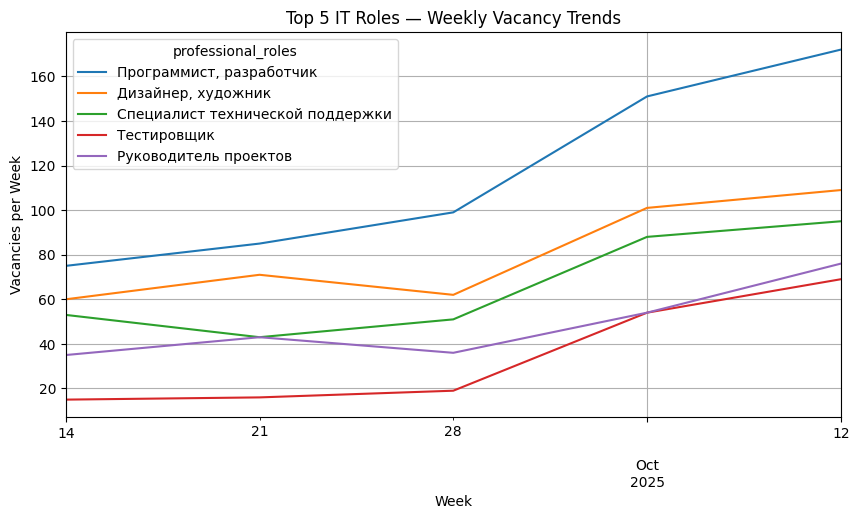

In [96]:
ets_forecast = {}

for role in pivot.columns:
    series = pivot[role]

    if len(series.dropna()) < min_points:
        continue
    
    model = ExponentialSmoothing(series, trend="add", seasonal=None)
    fitted = model.fit(optimized=True)

    forecast = fitted.forecast(steps = 1)
    prediction = pd.Series(forecast.values)

    ets_forecast[role] = float(prediction.iloc[-1])

rank = ranking(ets_forecast)
visualize_forecast(rank)

In [97]:
growth = {}
for role in ets_forecast.keys():
    last_value = pivot[role].iloc[-1]
    if last_value > 0:
        growth[role] = ((ets_forecast[role] - last_value) / last_value) * 100

growth_df = pd.Series(growth).sort_values(ascending=False)
print("Fastest Growing Roles:")
print(growth_df.head(10))


Fastest Growing Roles:
Гейм-дизайнер                        129.999999
Руководитель отдела аналитики         87.499997
Продуктовый аналитик                  53.333326
Технический писатель                  50.000019
DevOps-инженер                        45.833332
Руководитель группы разработки        43.846155
Дата-сайентист                        25.882359
BI-аналитик, аналитик данных          23.938072
Арт-директор, креативный директор     22.499982
Тестировщик                           13.623196
dtype: float64


<Axes: title={'center': 'Top 10 Fastest Growing IT Roles (%)'}>

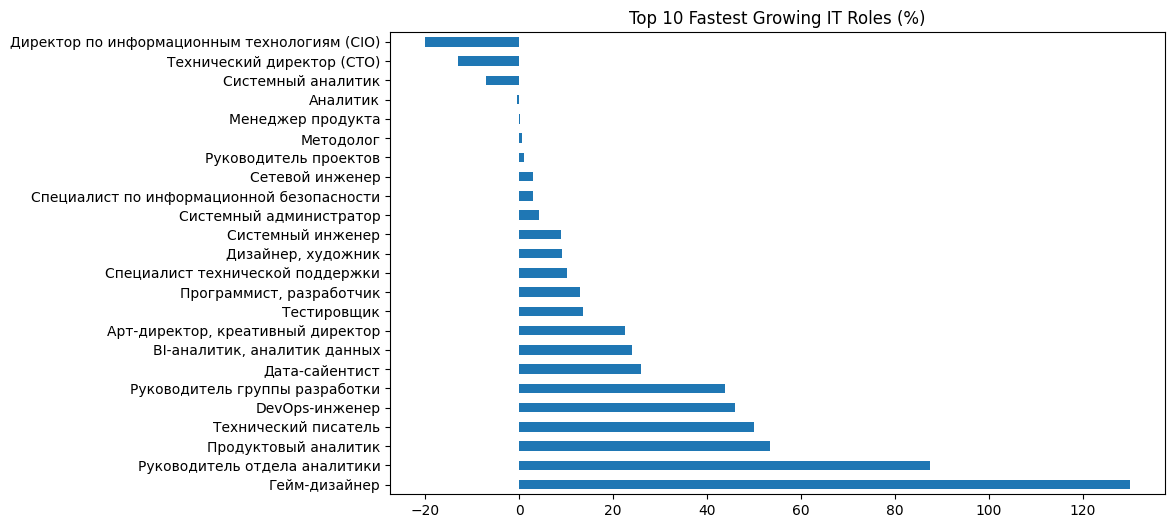

In [99]:
growth_df.plot(kind="barh", figsize=(10,6), title="Top 10 Fastest Growing IT Roles (%)")